### Histograms of catchment attributes & mean value per attribute and HUR

### Imports, US states shapes

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd

from matplotlib.ticker import FormatStrFormatter

from collections import defaultdict
from matplotlib.collections import PatchCollection
from matplotlib.patches import Polygon

from sklearn.preprocessing import StandardScaler, MinMaxScaler

import tqdm.notebook as tqmd

In [2]:
# load shapefile with HUCs for US
# hucs from 1..18 are CONUS, huc >18 is Alaska and islands

huc_map_df = gpd.read_file('data\HUC_shapes\wbdhu2_fixed_geom\wbdhu2_fixed_geom.shp')
hucs = sorted(huc_map_df.huc2.unique())[:-4]
huc_map_df = huc_map_df.loc[huc_map_df.huc2.isin(hucs)]

In [3]:
# table plotting style settings and functions

cell_hover = {  # for row hover use <tr> instead of <td>
    'selector': 'td:hover',
    'props': [('background-color', '#ffffb3')]}

def highlight_abs(x):
    return ['font-weight: bold' if abs(v) >= 100 else '' for v in x]
def highlight_rel(x):
    return ['font-weight: bold' if abs(v) >= 10 else '' for v in x]


# for larger plot labels etc
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

### Data Loading
 1. 27 catchment attributes: Camels US and HydroMT
 2. Camels US HUC numbers = hydrological response units (HUR)
 3. Camels US gauge location: longitude, latitude
 4. Combine attribute dataframe with HUC and lat/lon data
 5. Group HydroMT and Camels US dataframes by HUC 

In [6]:
# 1. Load attributes

# HydroMT
attributes_df_hydro = pd.read_csv('data/hydromt_attributes/ubasin_us.csv', header=0, dtype={'hru_id': str})
attributes_df_hydro = attributes_df_hydro.rename(columns= {'hru_id': 'basin', 
                                                           'area_km2': 'area_gages2', 
                                                           'soil_thickness': 'soil_depth_statsgo',
                                                           'ksatver_logmean': 'soil_conductivity',
                                                           'theta_s': 'max_water_content'})
attributes_df_hydro.index = attributes_df_hydro.basin
attributes_df_hydro = attributes_df_hydro.drop(columns='basin')

# CAMELS US 
attributes_df = pd.read_csv('data/camels_attributes/camels_attributes.csv', header=0, dtype={'basin': str})
attributes_df.index = attributes_df.basin
attributes_df = attributes_df.drop(columns='basin')
attributes_df = attributes_df[attributes_df.index.isin(attributes_df_hydro.index)]

# bring HydroMT columns in same order as in CAMELS US attributes_df
inserted_cols = attributes_df.columns
cols = ([col for col in inserted_cols if col in attributes_df_hydro] 
        + [col for col in attributes_df_hydro if col not in inserted_cols])
attributes_df_hydro = attributes_df_hydro[cols]

In [7]:
# 2. Load HRU associated with each catchment
huc_df = pd.read_csv('data/camels_attributes/camels_name.txt', sep=';', dtype={'gauge_id': str})
huc_df.index = huc_df.gauge_id
huc_df.drop(['gauge_id', 'gauge_name'], axis=1, inplace=True)
huc_df = huc_df[huc_df.index.isin(attributes_df_hydro.index)]

# 3. Load location (lat/lon) associated with each catchment
loc_df = pd.read_csv('data/camels_attributes/camels_topo.txt', sep=';', dtype={'gauge_id': str})
loc_df.index = loc_df.gauge_id
loc_df = loc_df[['gauge_lat', 'gauge_lon']]
loc_df = loc_df[loc_df.index.isin(attributes_df_hydro.index)]

# 4. combine CAMELS US and HydroMT attribtues with location, only those basins used for modeling (516)
attributes_df = pd.concat([attributes_df, huc_df], join='inner', axis=1)
attributes_df_hydro = pd.concat([attributes_df_hydro, huc_df], join='inner', axis=1)

In [8]:
# convert from mm/year to mm/day
# check if necessary or if alraedy in correct unit!!!

attributes_df_hydro['aridity'] = attributes_df_hydro['aridity'] / 365
attributes_df_hydro['pet_mean'] = attributes_df_hydro['pet_mean'] / 365

In [9]:
# 5. Get average attribute value per HUC for both datasets
grouped_camels = attributes_df.groupby(by='huc_02').mean()
grouped_hydro = attributes_df_hydro.groupby(by='huc_02').mean()

### Check for NaNs

In [10]:
rows_with_nan = [index for index, row in attributes_df_hydro.iterrows() if row.isnull().any()]
rows_with_nan

[]

### Histogram per attribute for US catchments
1. Create dictionary with attribtue anmes and units
2. Plot one histogram per attribute, HydroMT and Camels US in one plot
3. Plot one histogram per attribute, HydroMT and Camels US in seperate plots

In [11]:
# 1. Create dictionary with attribtue names and units, column names are dictionary keys

attribute_names = ['Mean precipitation', 'Aridity', 'Area', 'Mean elevation', 'High precip. duration', 'Fraction of snow', 
              'High precip. frequency', 'Mean slope', 'Geological permeability', 'Frac. of carbonate sedimentary rock', 
              'Clay fraction', 'Mean PET', 'Low precip. frequency', 'Soil depth to bedrock', 'Precip. seasonality',
              'Frac. of forest', 'Sand fraction', 'Saturated hyd. conductivity', 'Low precip. duration',
              'Max. green veg. frac. (GVF)', 'Annual GVF diff.', 'LAI diff.', 'Volumetric porosity', 'Soil depth', 
              'Max. LAI', 'Silt fraction', 'Max. water content', 'HRU']
units = ['mm/d', '-', 'km2', 'masl', 'd', '-', 'd/a', 'm/km', 'm2', '-',
        '%', 'mm/d', 'd/a', 'm', '-', '-', '%', 'cm/h', 'd', '-', 
        '-', '-', '-', 'm', '-', '%', 'm', 'HUC']

name_unit_dict = {}
for i, col in enumerate(attributes_df.columns):
    name_unit_dict[col] = {}
    name_unit_dict[col]['name'] = attribute_names[i]
    name_unit_dict[col]['unit'] = units[i]

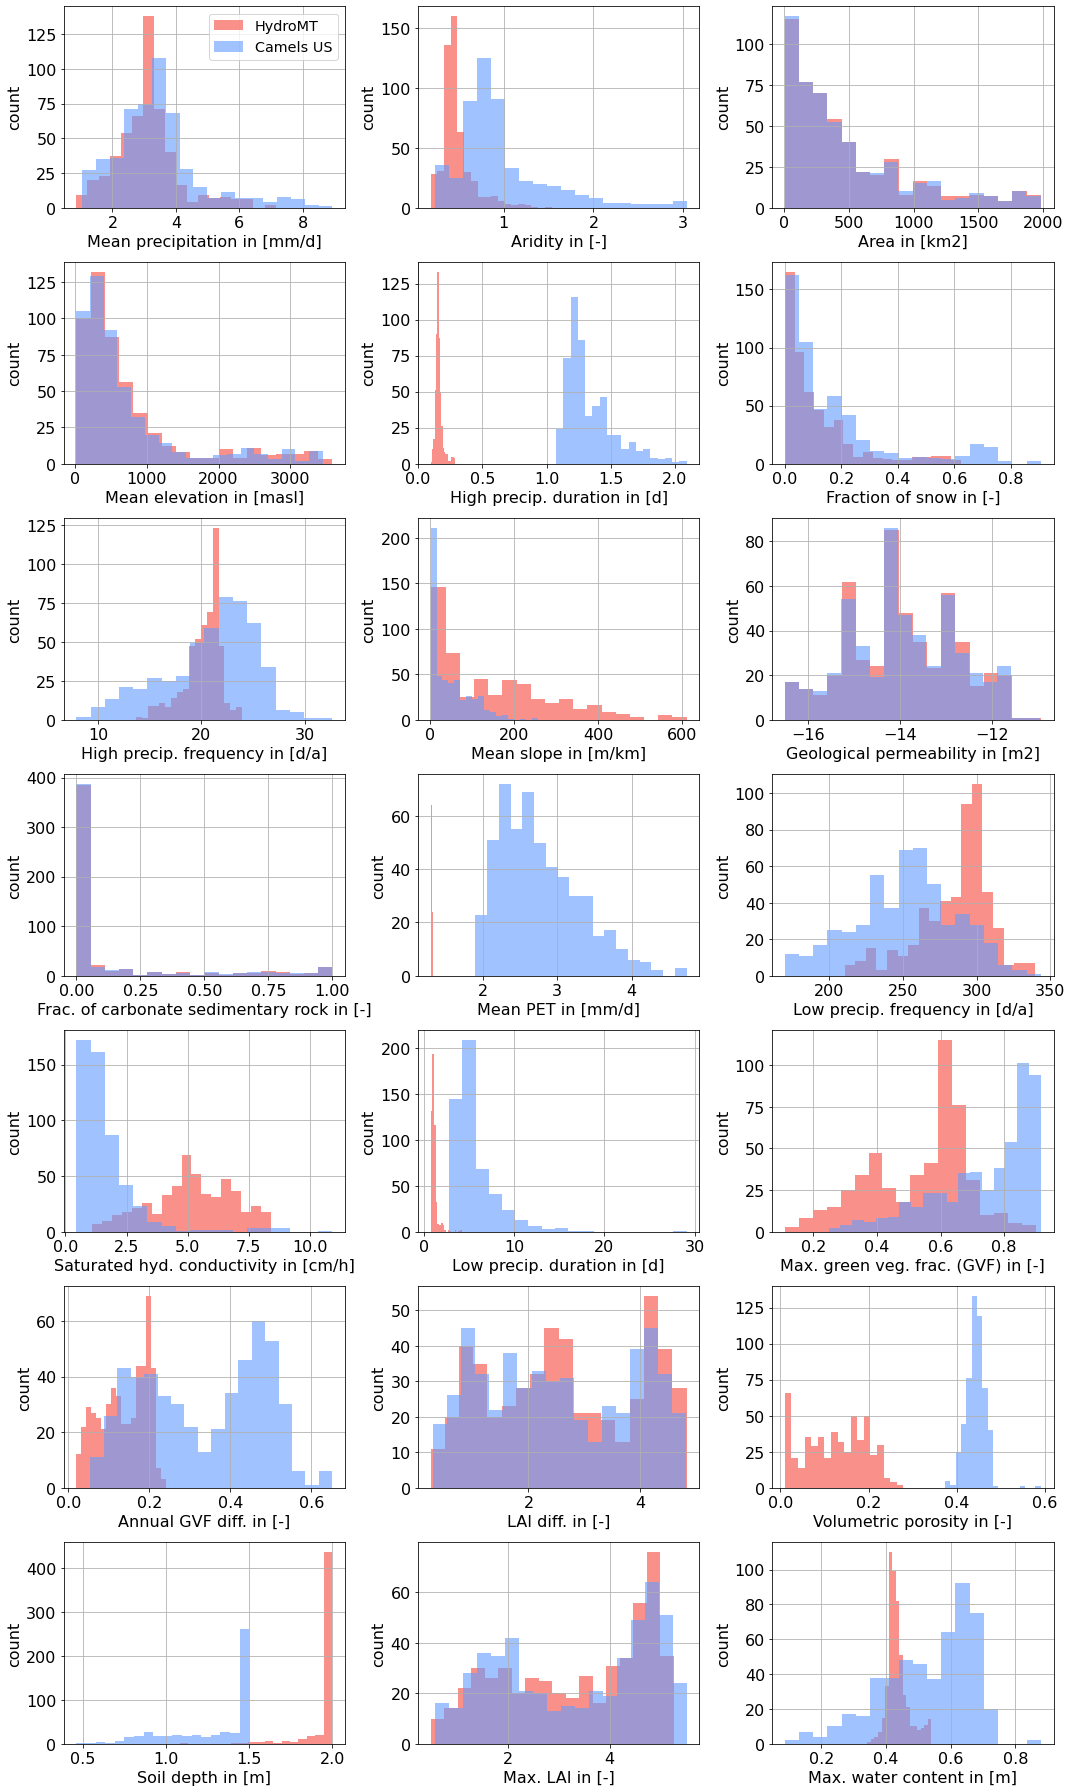

In [13]:
# 2. Plot one histogram per attribute, HydroMT and Camels US in one plot
# plotting with 18 bins to see nr of catchments per HUC in last histogram
camels_cols = attributes_df.columns
hydromt_cols = attributes_df_hydro.columns
colors = ['#f8766d', '#619cff'] # (red, blue)

fig, axes = plt.subplots(7, 3, figsize=(15, 25))
hist = attributes_df_hydro.drop(columns="huc_02").hist(bins=18, ax=axes, alpha=0.8, label='HydroMT', color=colors[0])

for i, ax in enumerate(hist.flatten()):
    col = hydromt_cols[i]
    name = name_unit_dict[col]['name']
    unit = name_unit_dict[col]['unit']
    attributes_df.hist(column=col, bins=18, ax=ax, alpha=0.6, label='Camels US', color=colors[1])
    ax.set_xlabel(f'{name} in [{unit}]', fontsize=16)
    ax.set_ylabel("count", fontsize=16)
    ax.tick_params('both', labelsize=16)
    ax.set_title('')
    if i==0:
        ax.legend()
    plt.tight_layout()

plt.savefig('plots/attributes_histograms')
plt.show()


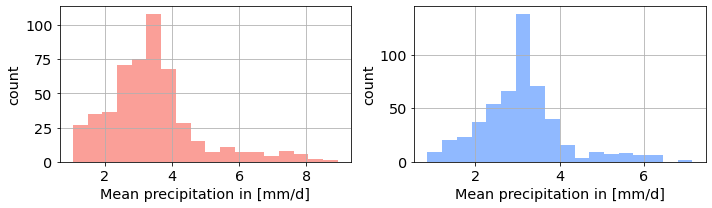

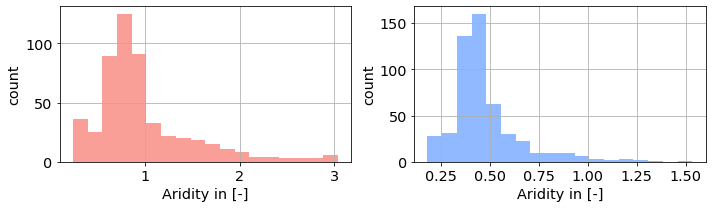

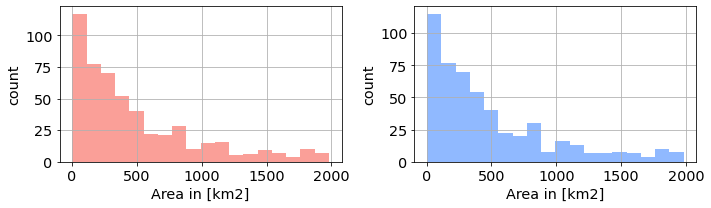

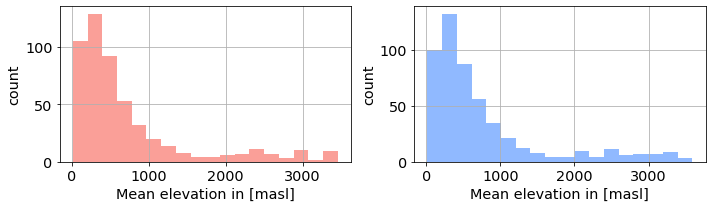

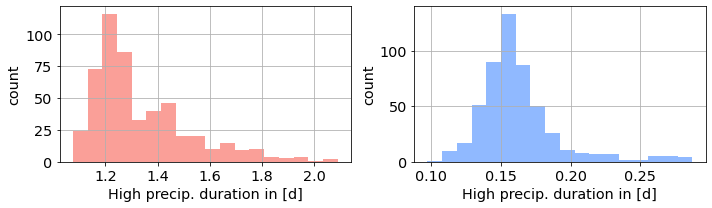

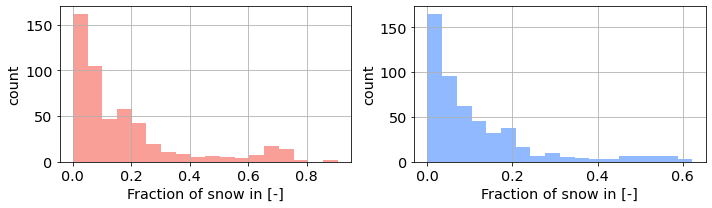

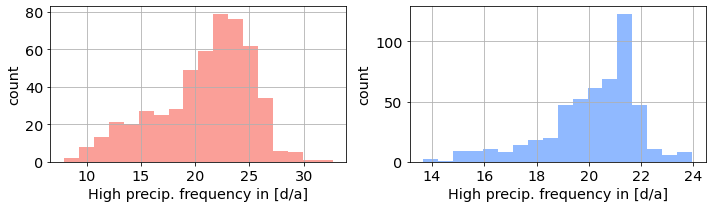

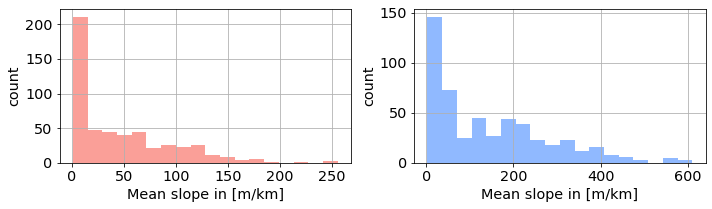

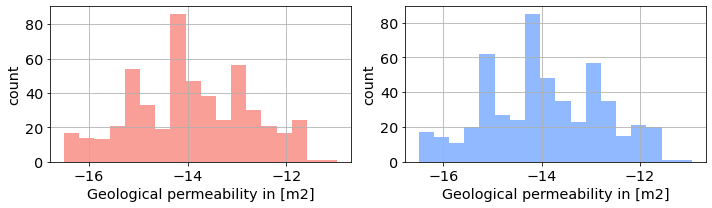

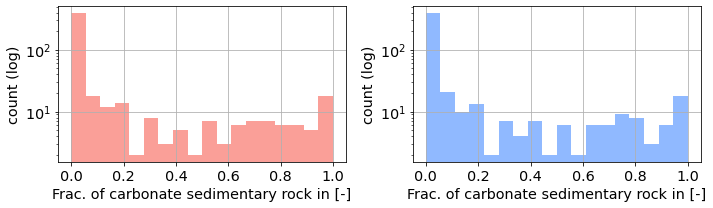

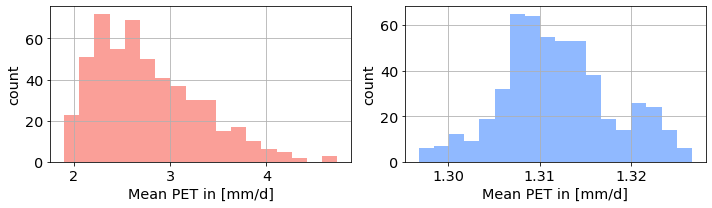

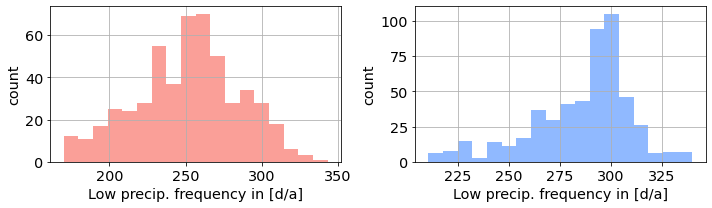

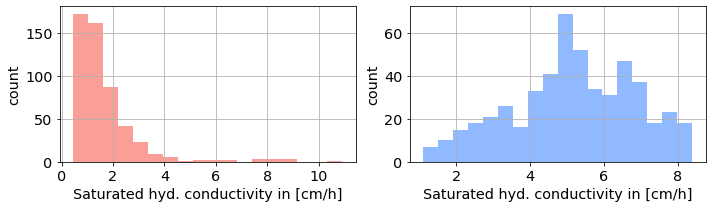

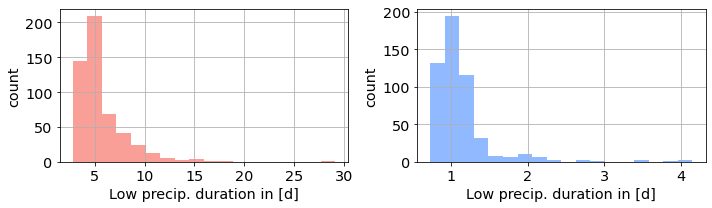

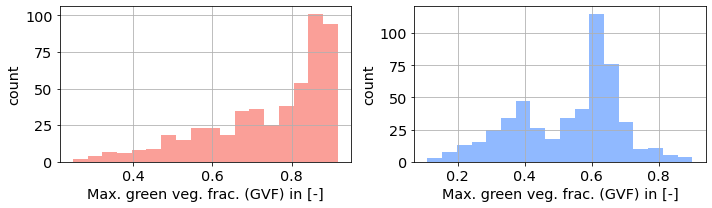

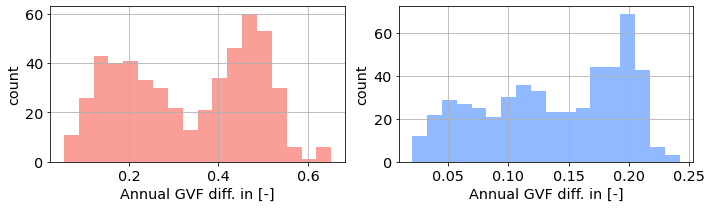

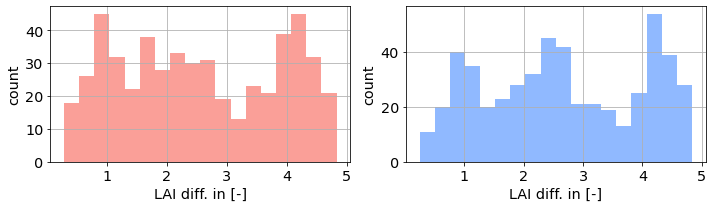

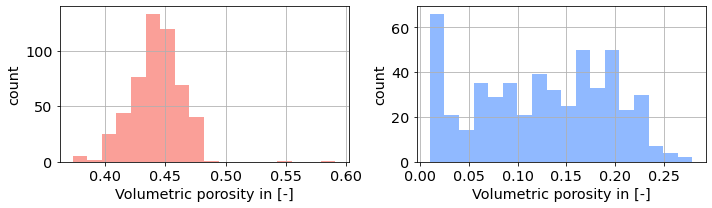

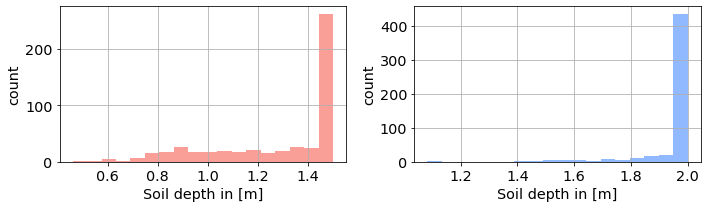

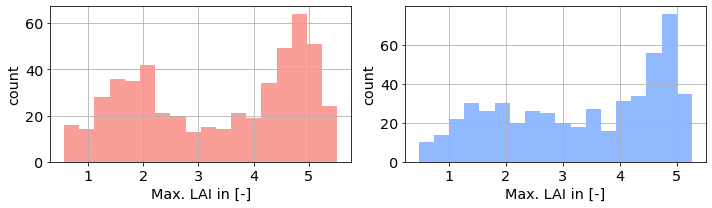

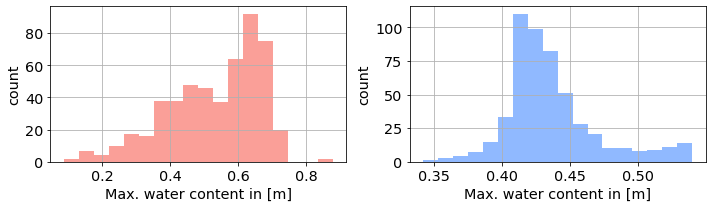

In [16]:
# 3. Plot one histogram per attribute, HydroMT and Camels US in seperate plot

plot_df = [attributes_df, attributes_df_hydro]
label = ['Camels US', 'HydroMT']
colors = ['#f8766d', '#619cff'] # (red, blue)

for i, col in enumerate(hydromt_cols):
    log = False
    count = 'count'
    if col == 'huc_02': 
        continue
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (10, 3))
    
    for j, ax in enumerate(fig.axes):
        if col == 'carb_rocks_frac':
            log = True
            count = 'count (log)'
        name = name_unit_dict[col]['name']
        unit = name_unit_dict[col]['unit']
        plot_df[j].hist(column=col, bins=18, ax=ax, alpha=0.7, label=label[j], color=colors[j], log=log)
        if col == 'pet_mean' and j ==1:
            ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        ax.set_xlabel(name + ' in [' + unit + ']')
        ax.set_ylabel(count)
        ax.set_title('')
    plt.tight_layout()
    plt.savefig('plots/attributes_histograms/' + col)
    plt.show()


### Mean value per  attribute for US regions (HUR)
1. Plot one histogram per HRU, HydroMT and Camels US in one plot
2. Plot one histogram per HRU, HydroMT and Camels US in seperate plot


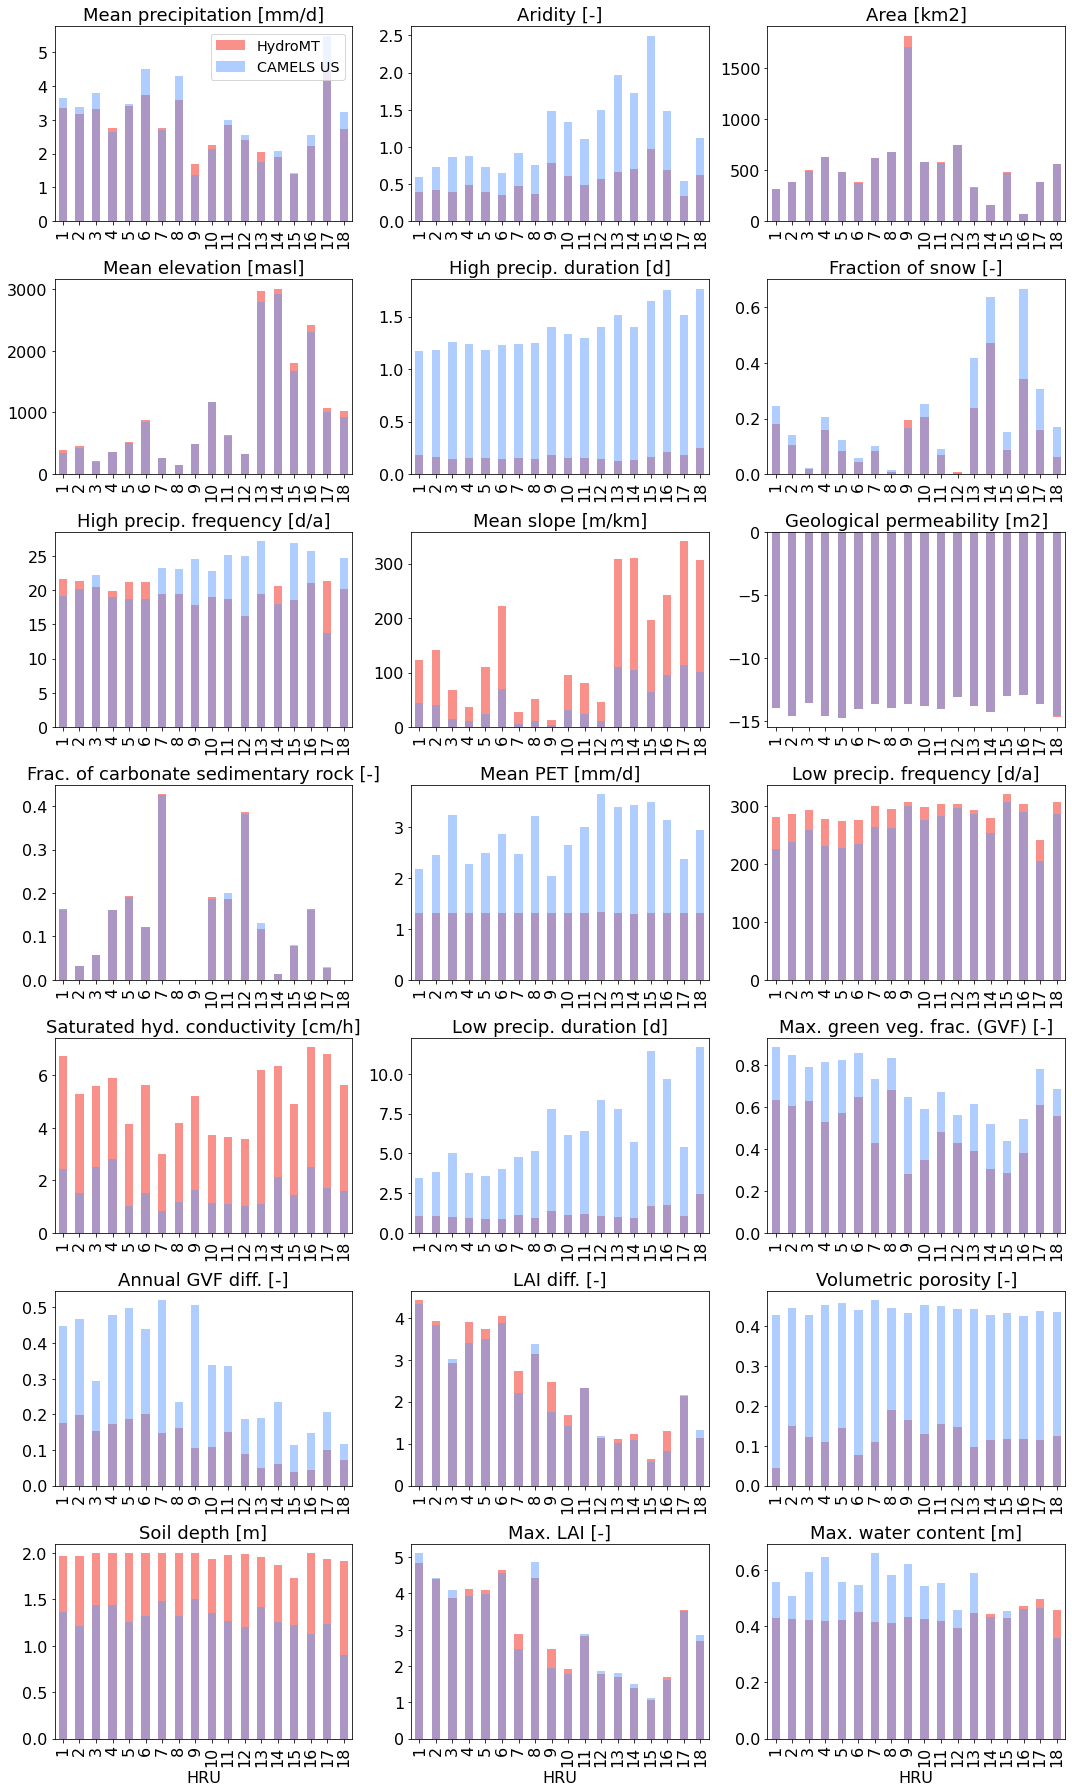

In [17]:
# 1. Plot one histogram per HRU, HydroMT and Camels US in one plot
fig, axes = plt.subplots(7, 3, figsize=(15, 25))

hist = grouped_hydro.plot(kind='bar', alpha=0.8, subplots=True, ax=axes, color=colors[0])

for i, ax in enumerate(hist.flatten()):
    col = hydromt_cols[i]
    name = name_unit_dict[col]['name']
    unit = name_unit_dict[col]['unit']
    grouped_camels[col].plot(kind='bar', alpha=0.5, ax=ax, color=colors[1])
    if i > 17:
        ax.set_xlabel('HRU', fontsize=16)
    else:
        ax.set_xlabel('')
    ax.tick_params('both', labelsize=16)
    ax.set_title(name + ' [' + unit + ']', fontsize=18)
    if i==0:
        ax.legend(['HydroMT', 'CAMELS US'])
    else:
        ax.get_legend().remove()
plt.tight_layout()
plt.savefig('plots/1plot_per_attribute')
plt.show()

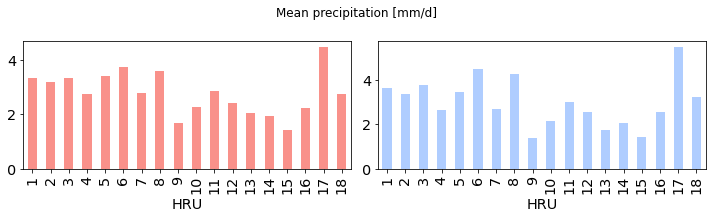

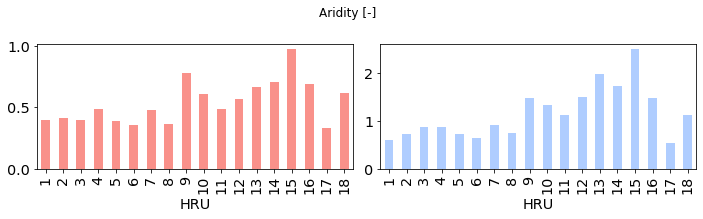

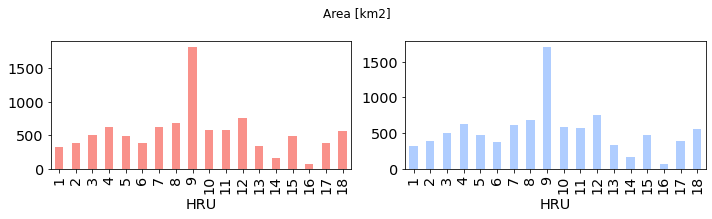

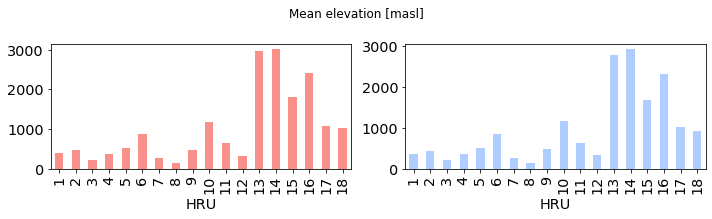

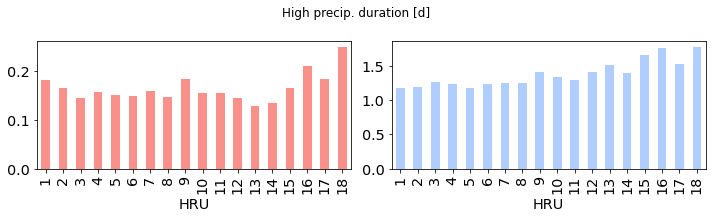

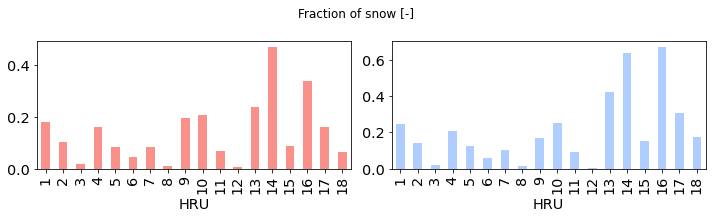

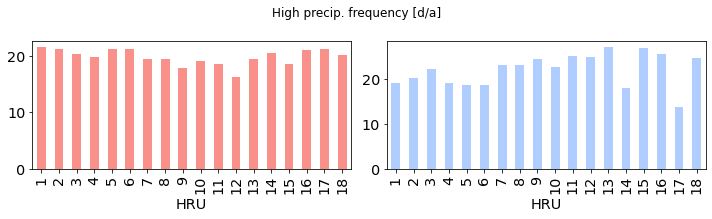

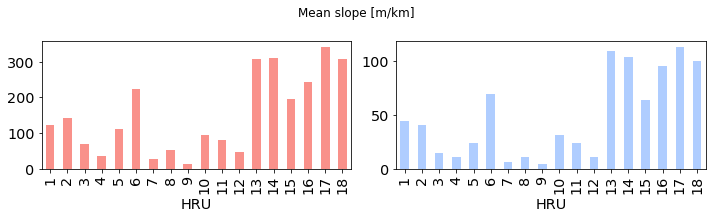

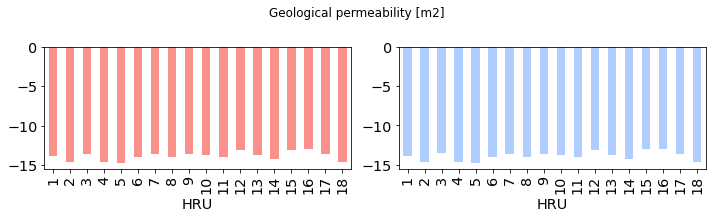

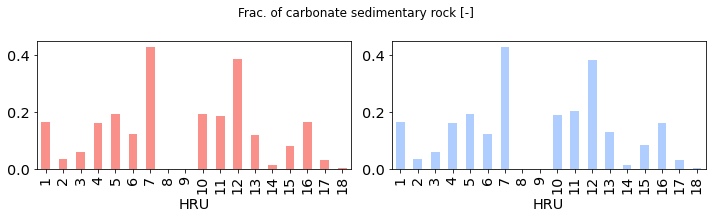

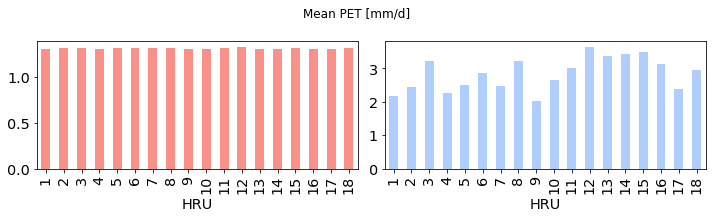

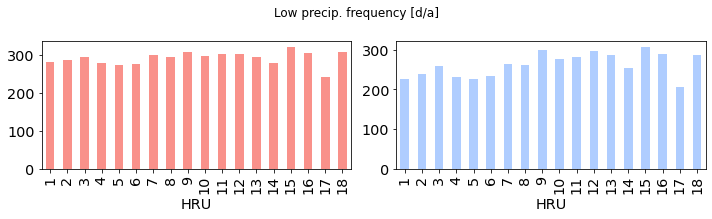

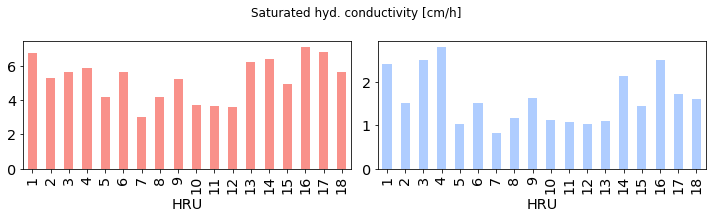

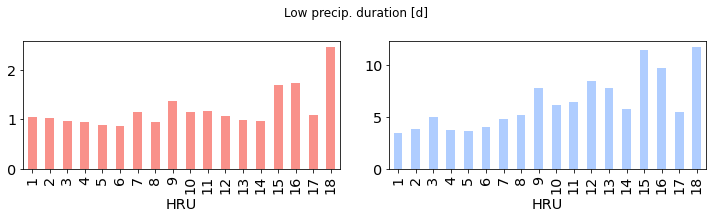

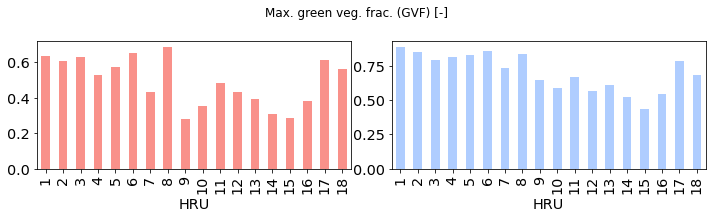

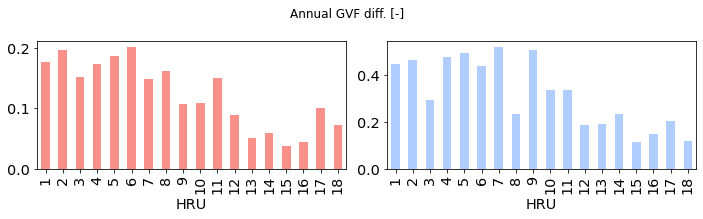

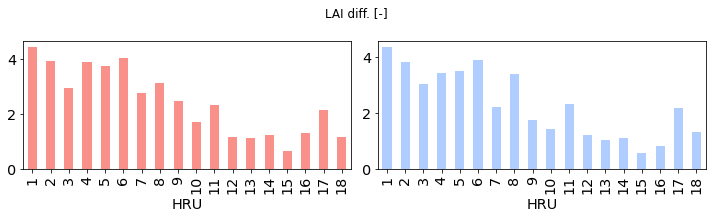

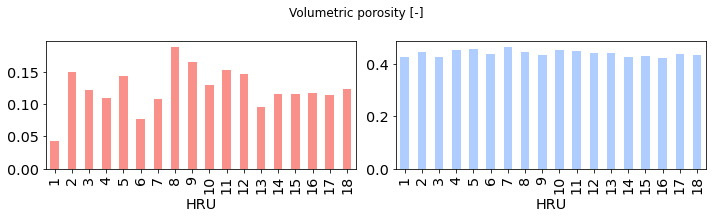

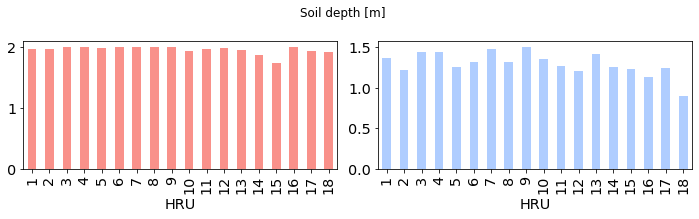

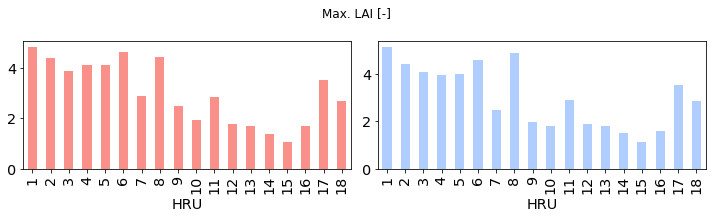

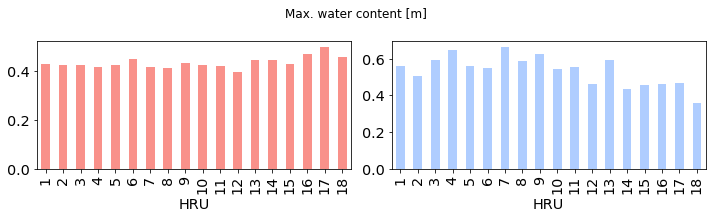

In [18]:
# 2. Plot one histogram per HRU, HydroMT and Camels US in seperate plot
for i, col in enumerate(grouped_hydro.columns):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (10, 3))
    
    grouped_hydro[col].plot(kind='bar', alpha=0.8, subplots=True, ax=ax[0], color=colors[0], label='HydroMT')
    name = name_unit_dict[col]['name']
    unit = name_unit_dict[col]['unit']
    grouped_camels[col].plot(kind='bar', alpha=0.5, ax=ax[1], color=colors[1], label='Camels US')
    ax[0].set_xlabel('HRU')
    ax[0].set_title('')
#     ax[0].legend()

    ax[1].set_xlabel('HRU')
    ax[1].set_title('')
#     ax[1].legend()
    
    plt.suptitle(name + ' [' + unit + ']', y=1)
    plt.tight_layout()
    plt.savefig('plots/attributes_per_huc/' + col)
    plt.show()